## Part B: Land Cover Modeling

### Summary of Work

In Part A, data preprocessing is performed on the original land cover dataset (2448 by 2448 RGB) satellite images with its corresponding (2448 by 2448 RGB) segmentation mask. These images are being resized to 224 by 224 RGB to accomodate to the deep learning task.

In Part B2, a pretrained EfficientNet model with imagenet weights replaces the encoder and achieved a validation accuracy of XX\%.

### Next Steps

In subsequent sprints, I outline the plan:

* Develop the computation for mean IoU using the sample GT labels and predicted labels
* Apply transfer learning to get improved accuracy and IoU (VGG and ResNet)
* Explore other light-weight models like MobileNet for deployment

---

### Notes

Below are the class labels:
The RGB values have been normalized from 0-255 to 0-1.

```
# RGB to Class Mapping
rgb_to_class = {
    (0, 1, 1): 1,  # urban_land
    (1, 1, 0): 2,  # agriculture_land
    (1, 0, 1): 3,  # rangeland
    (0, 1, 0): 4,  # forest_land
    (0, 0, 1): 5,  # water
    (1, 1, 1): 6,  # barren_land
    (0, 0, 0): 7  # unknown
} # one-indexing
```

### Mount Google Drive and load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/ad-hoc_data/archive/

 class_dict.csv		     'train_2024-02-23 07-47-59'  'train_2024-02-23 09-59-15'
 metadata.csv		     'train_2024-02-23 07-50-59'  'train_2024-02-23 09-59-29'
 test			     'train_2024-02-23 07-51-27'  'train_2024-02-23 10-00-14'
'train_2024-02-04 04-59-05'  'train_2024-02-23 07-53-07'  'train_2024-02-23 10-00-35'
'train_2024-02-04 15-39-27'  'train_2024-02-23 07-53-22'  'train_2024-02-23 10-00-59'
'train_2024-02-08 10-02-13'  'train_2024-02-23 07-54-35'  'train_2024-02-23 10-02-16'
'train_2024-02-08 10-35-12'  'train_2024-02-23 07-55-06'  'train_2024-02-24 05-59-54'
'train_2024-02-08 10-57-32'  'train_2024-02-23 08-55-11'  'train_2024-02-24 07-29-15'
'train_2024-02-13 04-08-53'  'train_2024-02-23 09-46-03'  'train_2024-02-24 09-03-49'
'train_2024-02-13 04-48-22'  'train_2024-02-23 09-48-39'  'train_2024-02-24 10-15-10'
'train_2024-02-13 06-27-35'  'train_2024-02-23 09-49-23'   u_net_4_stages_20240202.h5
'train_2024-02-14 05-29-53'  'train_2024-02-23 09-50-56'   valid
'train_2024-02-14 11-

In [ ]:
npy_folder = '/content/drive/MyDrive/ad-hoc_data/archive'

In [ ]:
import numpy as np

X_npy = np.load(npy_folder + "/x_images.npy")
y_npy = np.load(npy_folder + "/y_masks.npy")

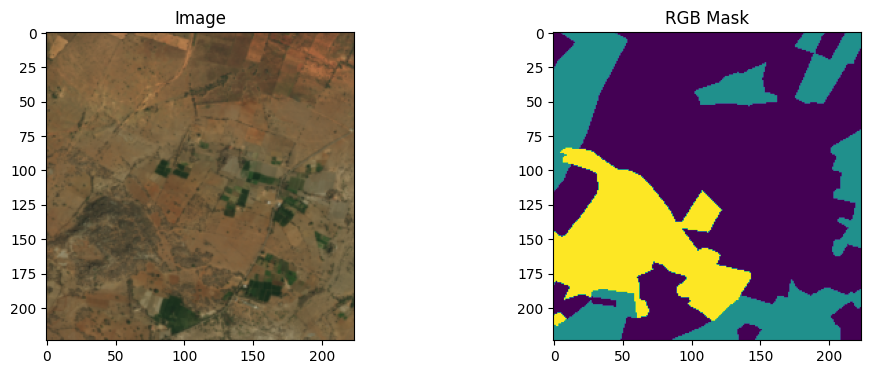

[[1. 1. 1. ... 2. 2. 2.]
 [1. 1. 1. ... 2. 2. 2.]
 [1. 1. 1. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 1. 1. 1.]
 [2. 2. 2. ... 1. 1. 1.]
 [2. 2. 2. ... 1. 1. 1.]]


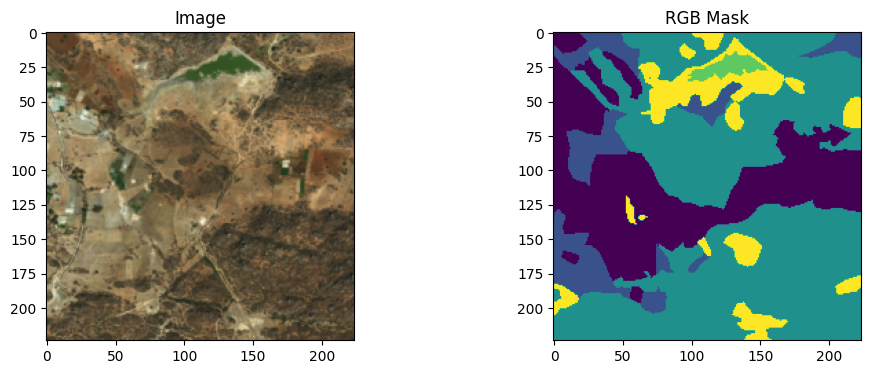

[[1. 1. 1. ... 2. 2. 2.]
 [1. 1. 1. ... 2. 2. 2.]
 [1. 1. 1. ... 2. 2. 2.]
 ...
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]]


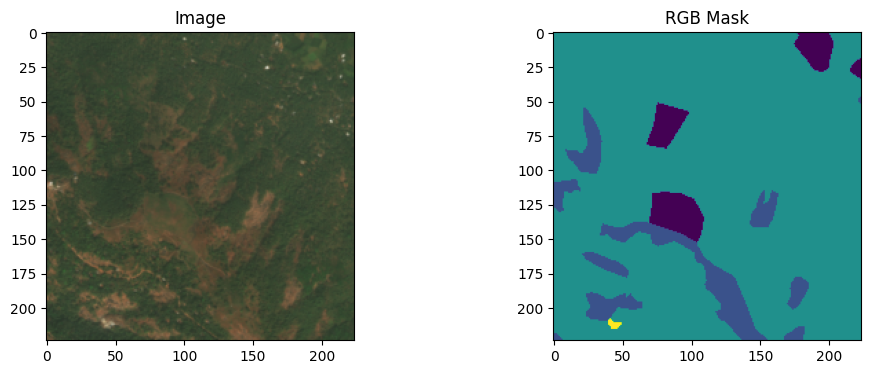

[[3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 ...
 [2. 2. 2. ... 3. 3. 3.]
 [2. 2. 2. ... 3. 3. 3.]
 [2. 2. 2. ... 3. 3. 3.]]


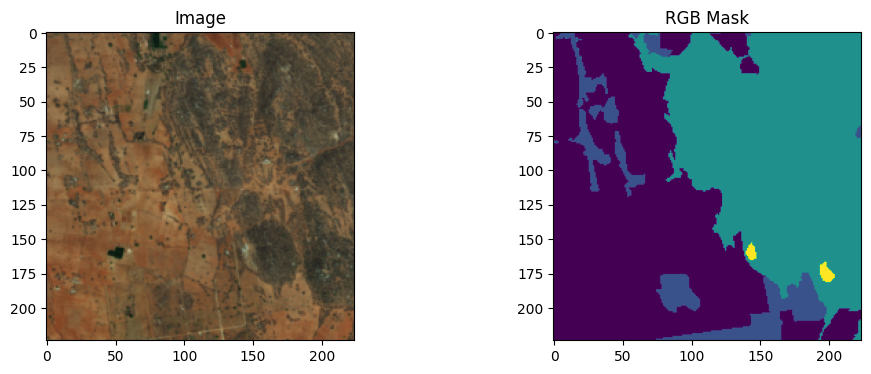

[[1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 3. 3. 3.]
 ...
 [1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 3. 3. 3.]]


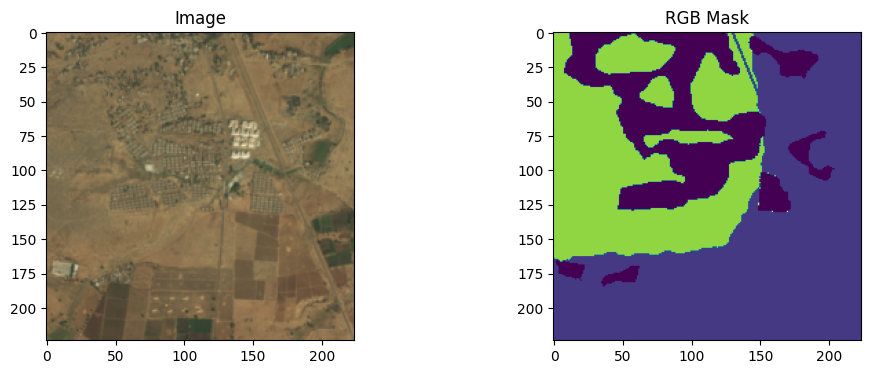

[[5. 5. 5. ... 1. 1. 1.]
 [5. 5. 5. ... 1. 1. 1.]
 [5. 5. 5. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


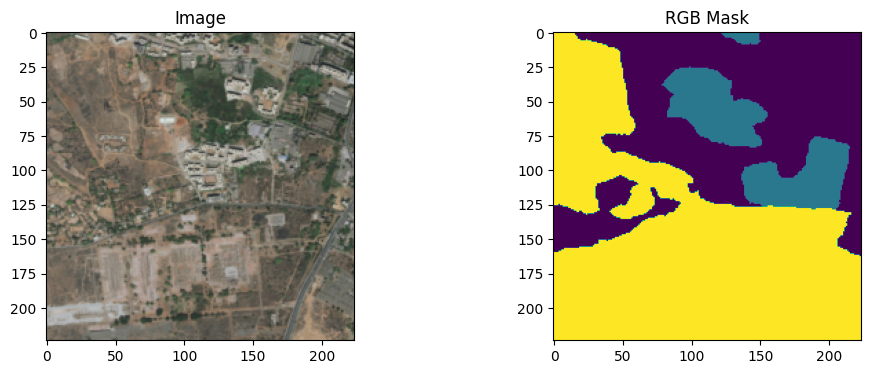

[[5. 5. 5. ... 0. 0. 0.]
 [5. 5. 5. ... 0. 0. 0.]
 [5. 5. 5. ... 0. 0. 0.]
 ...
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]]


In [ ]:
import matplotlib.pyplot as plt

images_list = [19, 181, 39, 258, 732, 454]

for image_idx in images_list:
    # Load the image and mask
    image = X_npy[image_idx].astype(np.float32)
    rgb_mask = y_npy[image_idx].astype(np.float32)

    # Example: Display the images
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(rgb_mask, cmap='viridis')


    plt.title('RGB Mask')

    plt.show()
    print(rgb_mask)


### Define RESNET-50

https://www.kaggle.com/code/aithammadiabdellatif/vgg16-u-net

Input: Accepts input tensors of shape input_shape.

Encoder (ResNet50):

Utilizes the pre-trained ResNet50 model with weights pre-loaded from the 'imagenet' dataset.
Extracts skip connections from intermediate layers:
Skip1: From the "conv2_block3_out" layer.
Skip2: From the "conv3_block4_out" layer.
Skip3: From the "conv4_block6_out" layer.
Skip4: From the "conv5_block3_out" layer.
Center:

Uses the output of the ResNet50 backbone as the center features.
Decoder:

Utilizes decoder blocks to upsample the features and incorporate skip connections:
Decoder block 1: Upsamples the center features and incorporates Skip4.
Decoder block 2: Upsamples the features from Decoder block 1 and incorporates Skip3.
Decoder block 3: Upsamples the features from Decoder block 2 and incorporates Skip2.
Decoder block 4: Upsamples the features from Decoder block 3 and incorporates Skip1.
Output:

Applies convolutional layers to reduce the number of channels and produce the final segmentation output.
The output shape matches the specified num_classes.
Activation:

Applies the softmax activation function to produce class probabilities for each pixel.
Model:

Combines the input and output layers to create the final ResNet50 U-Net model.
Overall, this architecture adapts the ResNet50 model for semantic segmentation tasks by incorporating skip connections through the U-Net architecture, enabling precise pixel-wise predictions.


The layers of VGG16 are:

```

['input_67', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1',

'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3',

'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool',

 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']
```

In [ ]:

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0

def conv_block(inputs, filterCount):
    x = Conv2D(filterCount, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filterCount, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip_features, filter_count):
    x = Conv2DTranspose(filter_count, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, filter_count)
    return x

def efficientnet_unet(input_shape, num_classes=7):
    inputs = Input(input_shape, name='input')

    efficientnet = EfficientNetB0(include_top=False, weights="imagenet", drop_connect_rate=0.4, input_tensor=inputs)

    # Encoder
    s1 = inputs
    s2 = efficientnet.get_layer("block1a_activation").output
    s3 = efficientnet.get_layer("block2b_activation").output
    s4 = efficientnet.get_layer("block3b_activation").output
    x = efficientnet.get_layer("block4a_activation").output

    # Decoder
    x = decoder_block(x, s4, 512)
    x = decoder_block(x, s3, 256)
    x = decoder_block(x, s2, 128)
    x = decoder_block(x, s1, 64)

    outputs = Conv2D(num_classes, 1, activation="softmax")(x)

    model = Model(inputs, outputs, name="EfficientNet_U-Net")

    return model

# Define input shape
input_shape = (224, 224, 3)

# Create and summarize the model
model = efficientnet_unet(input_shape)
model.summary()



16705208/16705208 [==============================] - 2s 0us/step
Model: "EfficientNet_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input[0][0]']               
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Re

In [ ]:
input_shape = (224,224,3)
model = efficientnet_unet(input_shape)
model.summary()


Model: "EfficientNet_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input[0][0]']               
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalizati

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# Assuming input images are 224x224 with 3 channels
input_shape = (224, 224, 3)
num_classes = 7  # 7 classes based on your provided RGB mapping

# One-Hot Encode Integer Masks
y_one_hot = to_categorical(y_npy, num_classes=num_classes)

print(y_one_hot.shape)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_npy, y_one_hot, test_size=0.2, random_state=42)

(803, 224, 224, 7)


In [ ]:
from keras import backend as K

def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [ ]:
import os
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler


training_session_id = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
training_session_folder = '/content/drive/MyDrive/ad-hoc_data/archive/train_%s' % (training_session_id)
os.makedirs(training_session_folder, exist_ok=True)

# Learning rate scheduler function
def lr_scheduler(epoch, lr, factor=.95):
    if epoch % 3 == 0 and epoch > 0:
        return lr * factor  # Adjust the factor as needed
    return lr

# Learning rate scheduler callback
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Callbacks list with ModelCheckpoint and LearningRateScheduler
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=training_session_folder + '/u_net_model.{epoch:04d}-acc-{accuracy:4.2f}-val_acc-{val_accuracy:4.2f}-loss-{val_loss:4.2f}.h5',
        monitor='val_loss', save_best_only=True),
    lr_scheduler_callback
]


# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

print("Shapes:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)\

# del y_one_hot, X_npy, y_npy

# Compile the model with Categorical Crossentropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', jaccard_distance])

Shapes:
X_train: (642, 224, 224, 3)
X_val: (161, 224, 224, 3)
y_train: (642, 224, 224, 7)
y_val: (161, 224, 224, 7)


In [ ]:
# Ensure the input shape of your data matches the model's input shape
print("Input shape of X_train:", X_train.shape)
print("Input shape of y_train:", y_train.shape)
print("Input shape of X_val:", X_val.shape)
print("Input shape of y_val:", y_val.shape)
print("Model input shape:", model.input_shape)



Input shape of X_train: (642, 224, 224, 3)
Input shape of y_train: (642, 224, 224, 7)
Input shape of X_val: (161, 224, 224, 3)
Input shape of y_val: (161, 224, 224, 7)
Model input shape: (None, 224, 224, 3)


In [ ]:
# Training loop
epochs = 130
batch_size = 32

# Use the iterators in your training loop
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

# Create iterators for the training and validation data
train_iterator = datagen.flow(X_train, y_train, batch_size=batch_size)
val_iterator = datagen.flow(X_val, y_val, batch_size=batch_size)

# Training with fit function
history = model.fit(train_iterator, steps_per_epoch=steps_per_epoch,
                    validation_data=val_iterator, validation_steps=validation_steps,
                    epochs=epochs, callbacks=callbacks_list)



Epoch 1/130
20/20 [==============================] - ETA: 0s - loss: 1.6816 - accuracy: 0.4742 - jaccard_distance: 1.4598

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 85s 2s/step - loss: 1.6816 - accuracy: 0.4742 - jaccard_distance: 1.4598 - val_loss: 2.8851 - val_accuracy: 0.5655 - val_jaccard_distance: 0.9072 - lr: 0.0010
Epoch 2/130
20/20 [==============================] - 23s 1s/step - loss: 1.2205 - accuracy: 0.6359 - jaccard_distance: 1.1526 - val_loss: 3.4830 - val_accuracy: 0.5652 - val_jaccard_distance: 0.8695 - lr: 0.0010
Epoch 3/130
20/20 [==============================] - 23s 1s/step - loss: 1.1109 - accuracy: 0.6577 - jaccard_distance: 1.0352 - val_loss: 2.0583 - val_accuracy: 0.5609 - val_jaccard_distance: 1.0119 - lr: 0.0010
Epoch 4/130
20/20 [==============================] - 24s 1s/step - loss: 1.0436 - accuracy: 0.6740 - jaccard_distance: 0.9645 - val_loss: 3.3626 - val_accuracy: 0.5666 - val_jaccard_distance: 0.8668 - lr: 9.5000e-04
Epoch 5/130
20/20 [==============================] - 24s 1s/step - loss: 0.9989 - accuracy: 0.6843 - jaccard_distance: 0.9405 - val_loss: 1.5873 - val_accuracy:

In [ ]:
# 3 - Load checkpointed model for continuation of training or predict validation set
from tensorflow.keras.models import load_model

# model = load_model('/content/drive/MyDrive/ad-hoc_data/archive/train_2024-02-17 12-38-44/u_net_model.0077-acc-0.78-val_acc-0.66-loss-0.95.h5')

1/1 [==============================] - 3s 3s/step


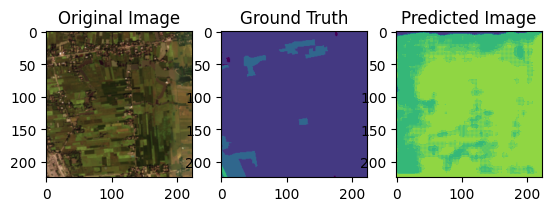

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [3 3 3 ... 2 2 2]
 [3 3 3 ... 2 2 2]
 [3 3 3 ... 2 2 2]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 5 6 2]
 ...
 [2 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [2 6 6 ... 6 6 6]]
The unique GT class labels are [1 2 3 5]
The unique predicted class labels are [2 5 6]
1/1 [==============================] - 0s 26ms/step


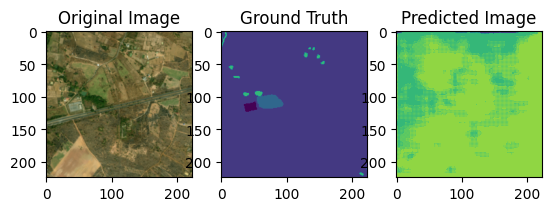

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
[[2 2 2 ... 2 6 2]
 [2 2 2 ... 6 6 2]
 [2 2 2 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
The unique GT class labels are [1 2 3 5]
The unique predicted class labels are [2 5 6]
1/1 [==============================] - 0s 22ms/step


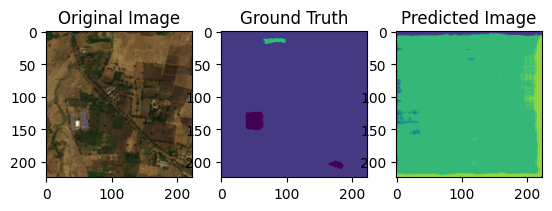

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [2 6 6 ... 6 6 2]]
The unique GT class labels are [1 2 5 6]
The unique predicted class labels are [2 5 6]
1/1 [==============================] - 0s 21ms/step


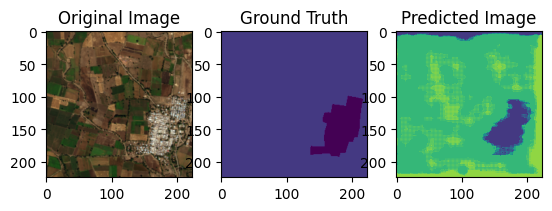

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [2 6 6 ... 6 6 6]]
The unique GT class labels are [1 2]
The unique predicted class labels are [2 5 6]
1/1 [==============================] - 0s 21ms/step


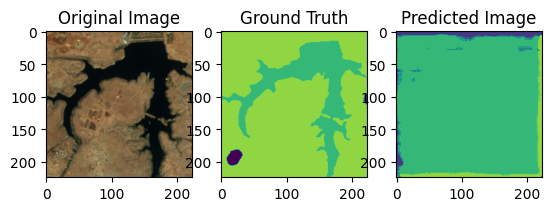

[[6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 6 2 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [2 6 2 ... 6 6 2]]
The unique GT class labels are [1 2 5 6]
The unique predicted class labels are [2 5 6]
1/1 [==============================] - 0s 21ms/step


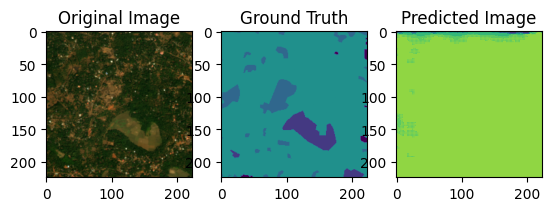

[[4 4 4 ... 3 3 3]
 [4 4 4 ... 3 3 3]
 [4 4 4 ... 3 3 3]
 ...
 [1 1 4 ... 4 4 4]
 [1 1 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]]
[[2 2 2 ... 2 6 2]
 [2 2 2 ... 6 6 2]
 [2 2 2 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
The unique GT class labels are [1 2 3 4]
The unique predicted class labels are [2 5 6]
1/1 [==============================] - 0s 22ms/step


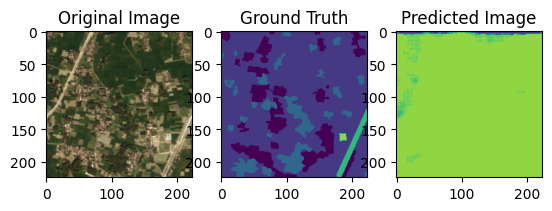

[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]]
[[2 2 2 ... 2 2 2]
 [2 6 2 ... 2 2 2]
 [2 2 2 ... 2 6 2]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
The unique GT class labels are [1 2 3 5 6]
The unique predicted class labels are [2 5 6]
1/1 [==============================] - 0s 22ms/step


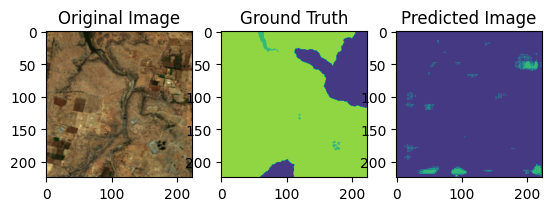

[[6 6 6 ... 2 2 2]
 [6 6 6 ... 2 2 2]
 [6 6 6 ... 2 2 2]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 6 2]
 [2 2 2 ... 2 6 2]
 [2 2 2 ... 2 2 2]]
The unique GT class labels are [2 5 6]
The unique predicted class labels are [2 5 6]
1/1 [==============================] - 0s 20ms/step


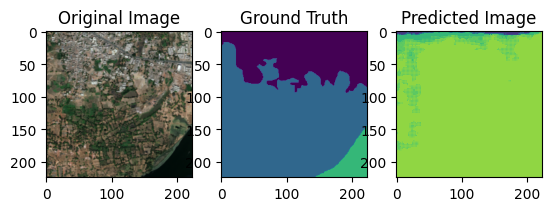

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [3 3 3 ... 5 5 5]
 [3 3 3 ... 5 5 5]
 [3 3 3 ... 5 5 5]]
[[2 2 2 ... 2 6 2]
 [2 2 2 ... 5 6 6]
 [2 2 2 ... 5 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
The unique GT class labels are [1 3 5]
The unique predicted class labels are [2 5 6]
1/1 [==============================] - 0s 21ms/step


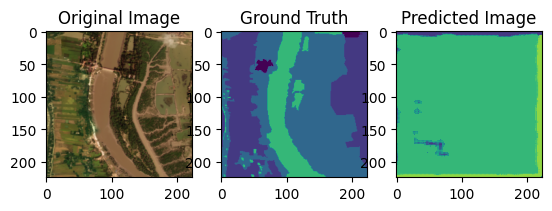

[[3 3 3 ... 2 2 2]
 [3 3 3 ... 2 2 2]
 [3 3 3 ... 2 2 2]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [2 6 6 ... 6 6 2]]
The unique GT class labels are [1 2 3 5]
The unique predicted class labels are [2 5 6]
1/1 [==============================] - 0s 20ms/step


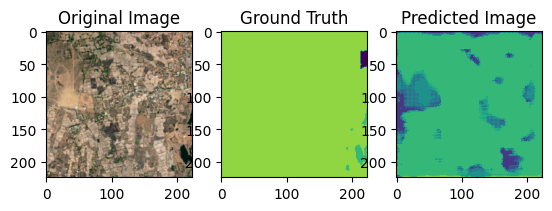

[[6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [4 2 2 ... 5 6 2]
 [2 6 2 ... 5 6 6]
 [2 6 2 ... 6 6 2]]
The unique GT class labels are [1 5 6]
The unique predicted class labels are [2 4 5 6]
1/1 [==============================] - 0s 20ms/step


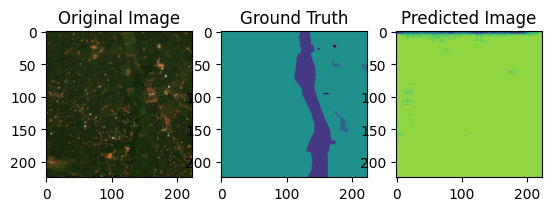

[[4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 ...
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 6 2 2]
 [2 2 2 ... 6 6 2]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
The unique GT class labels are [1 2 3 4]
The unique predicted class labels are [2 5 6]
1/1 [==============================] - 0s 20ms/step


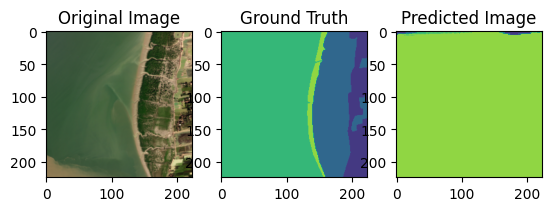

[[5 5 5 ... 2 2 2]
 [5 5 5 ... 2 2 2]
 [5 5 5 ... 2 2 2]
 ...
 [5 5 5 ... 2 2 2]
 [5 5 5 ... 2 2 2]
 [5 5 5 ... 2 2 2]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 6 6 2]
 [2 2 2 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
The unique GT class labels are [2 3 5 6]
The unique predicted class labels are [2 5 6]
1/1 [==============================] - 0s 20ms/step


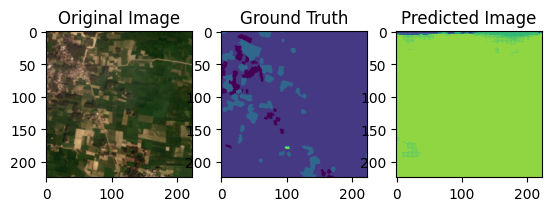

[[3 3 3 ... 2 2 2]
 [3 3 3 ... 2 2 2]
 [3 3 3 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 6 6 2]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
The unique GT class labels are [1 2 3 6]
The unique predicted class labels are [2 5 6]
1/1 [==============================] - 0s 21ms/step


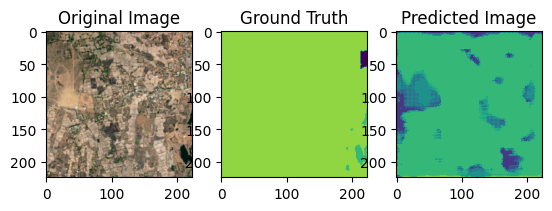

[[6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [4 2 2 ... 5 6 2]
 [2 6 2 ... 5 6 6]
 [2 6 2 ... 6 6 2]]
The unique GT class labels are [1 5 6]
The unique predicted class labels are [2 4 5 6]
1/1 [==============================] - 0s 30ms/step


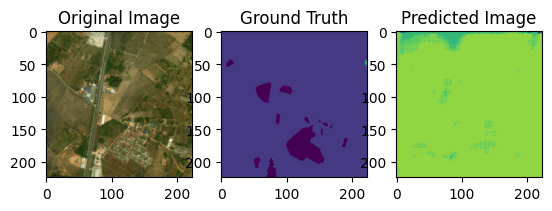

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
[[2 2 2 ... 2 2 2]
 [2 6 6 ... 2 2 2]
 [2 6 6 ... 2 6 2]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
The unique GT class labels are [1 2 5 7]
The unique predicted class labels are [2 5 6]
1/1 [==============================] - 0s 21ms/step


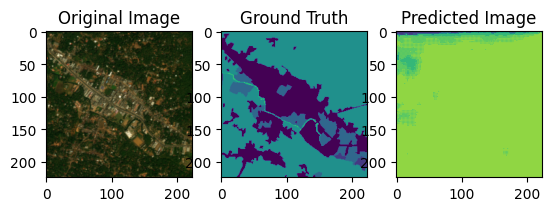

[[4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 ...
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 6 6 2]
 [2 2 2 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
The unique GT class labels are [1 2 3 4 5]
The unique predicted class labels are [2 5 6]
1/1 [==============================] - 0s 22ms/step


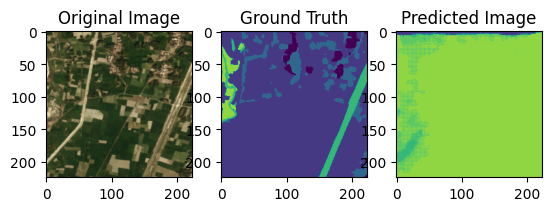

[[2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 ...
 [2 2 2 ... 3 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 6 6 2]
 [2 2 2 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
The unique GT class labels are [1 2 3 5 6]
The unique predicted class labels are [2 5 6]
1/1 [==============================] - 0s 23ms/step


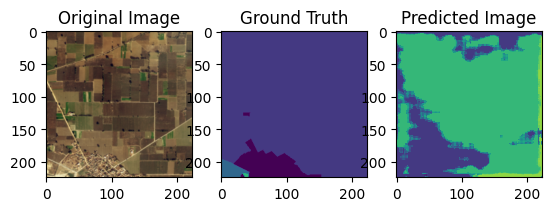

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [3 3 3 ... 2 2 2]
 [3 3 3 ... 2 2 2]
 [3 3 3 ... 2 2 2]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 6 6 6]
 [2 2 2 ... 6 6 6]
 [2 2 2 ... 6 6 2]]
The unique GT class labels are [1 2 3 5]
The unique predicted class labels are [1 2 5 6]
1/1 [==============================] - 0s 21ms/step


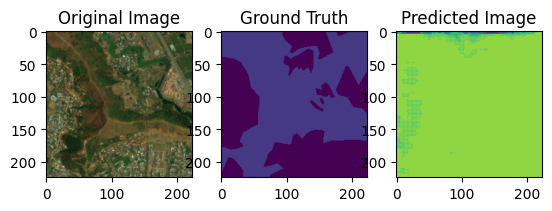

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[2 2 2 ... 6 6 2]
 [2 6 2 ... 6 6 6]
 [2 6 2 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
The unique GT class labels are [1 2]
The unique predicted class labels are [2 5 6]


In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img

# Prediction loop
num_samples_to_predict = 20  # change here for the number of images to predict

for _ in range(num_samples_to_predict):
    # Generate a random index for prediction
    random_index = np.random.randint(0, len(X_val))

    # Select a sample from the validation set
    sample_image = X_val[random_index]
    sample_one_hot_label = y_val[random_index]

    # Expand dimensions to match the model input shape
    sample_image = np.expand_dims(sample_image, axis=0)

    # Make the prediction
    predictions = model.predict(sample_image)

    # Convert predictions to categorical indices
    predicted_label_indices = np.argmax(predictions, axis=-1) + 1

    # Convert one-hot encoded label to categorical indices
    sample_label_indices = np.argmax(sample_one_hot_label, axis=-1) + 1

    # Display the original image
    plt.subplot(1, 3, 1)
    plt.imshow(array_to_img(sample_image.squeeze()))
    plt.title("Original Image")

    # Display the ground truth (categorical indices, one-indexed)
    plt.subplot(1, 3, 2)
    plt.imshow(sample_label_indices, cmap='viridis', vmin=1, vmax=7)
    plt.title("Ground Truth")

    # Display the predicted image (categorical index, one-indexed)
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_label_indices.squeeze(), cmap='viridis', vmin=1, vmax=7)
    plt.title("Predicted Image")

    plt.show()
    print(sample_label_indices)
    print(predicted_label_indices.squeeze())
    print(f'The unique GT class labels are {np.unique(sample_label_indices)}')
    print(f'The unique predicted class labels are {np.unique(predicted_label_indices.squeeze())}')

Display classification metric report

In [ ]:
# Create list of land cover categorical labels that correspond to the predicted index labels
labels = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']

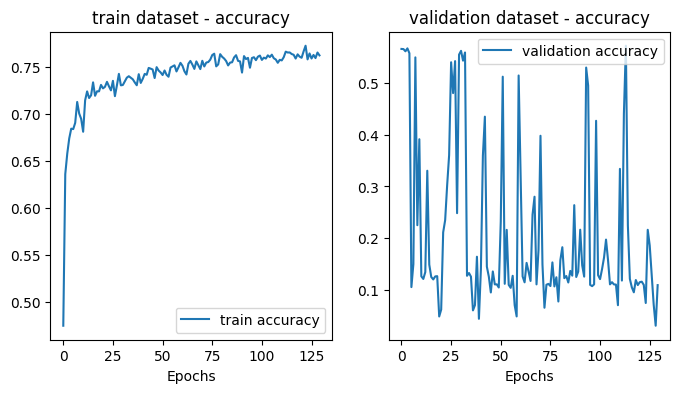

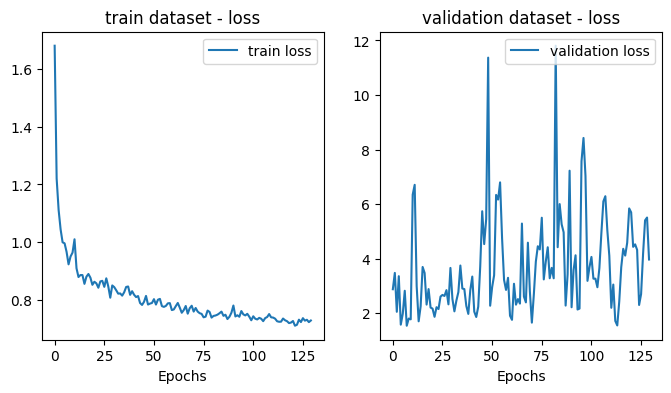

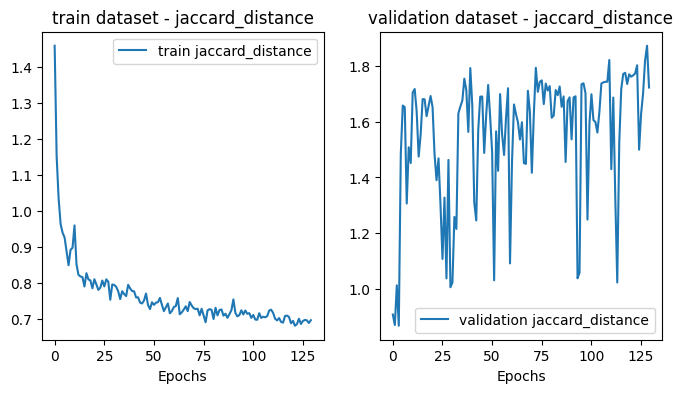

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def display_metrics(history, metric='accuracy'):
    plt.figure(figsize=(8, 4))

    # Train Data Metrics
    plt.subplot(1, 2, 1)
    plt.plot(history.history[metric], label=f'train {metric}')
    plt.title(f'train dataset - {metric}')
    plt.xlabel('Epochs')
    plt.legend()

    # Test Data Metrics
    plt.subplot(1, 2, 2)
    val_metric = f'val_{metric}'  # Use val_accuracy and val_loss for validation metrics
    plt.plot(history.history[val_metric], label=f'validation {metric}')
    plt.title(f'validation dataset - {metric}')
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()

# Assuming `history` is the history object returned by model.fit
display_metrics(history, 'accuracy')
display_metrics(history, 'loss')
display_metrics(history, 'jaccard_distance')


Display classification report and confusion matrix

In [ ]:
# convert y_train and y_val from one-hot encoding formatted predictions to categorical labels

# Convert predictions to categorical indices
# y_train_index = np.argmax(y_train, axis=-1)
# y_val_index = np.argmax(y_val, axis=-1)

In [ ]:
# y_train_index = y_train.reshape(1, -1)
# y_val_index = y_val.reshape(1, -1)

print(y_train.shape)

(642, 224, 224, 7)


In [ ]:
import numpy as np

# Assuming your array is named 'original_array'
original_shape = (2, 256, 256, 7)
original_array = np.random.random(original_shape)

# Reshape the array
flattened_array = original_array.reshape(-1, original_shape[-1])

print(original_shape[-1])

print(flattened_array.shape)


7
(131072, 7)


6/6 [==============================] - 1s 265ms/step


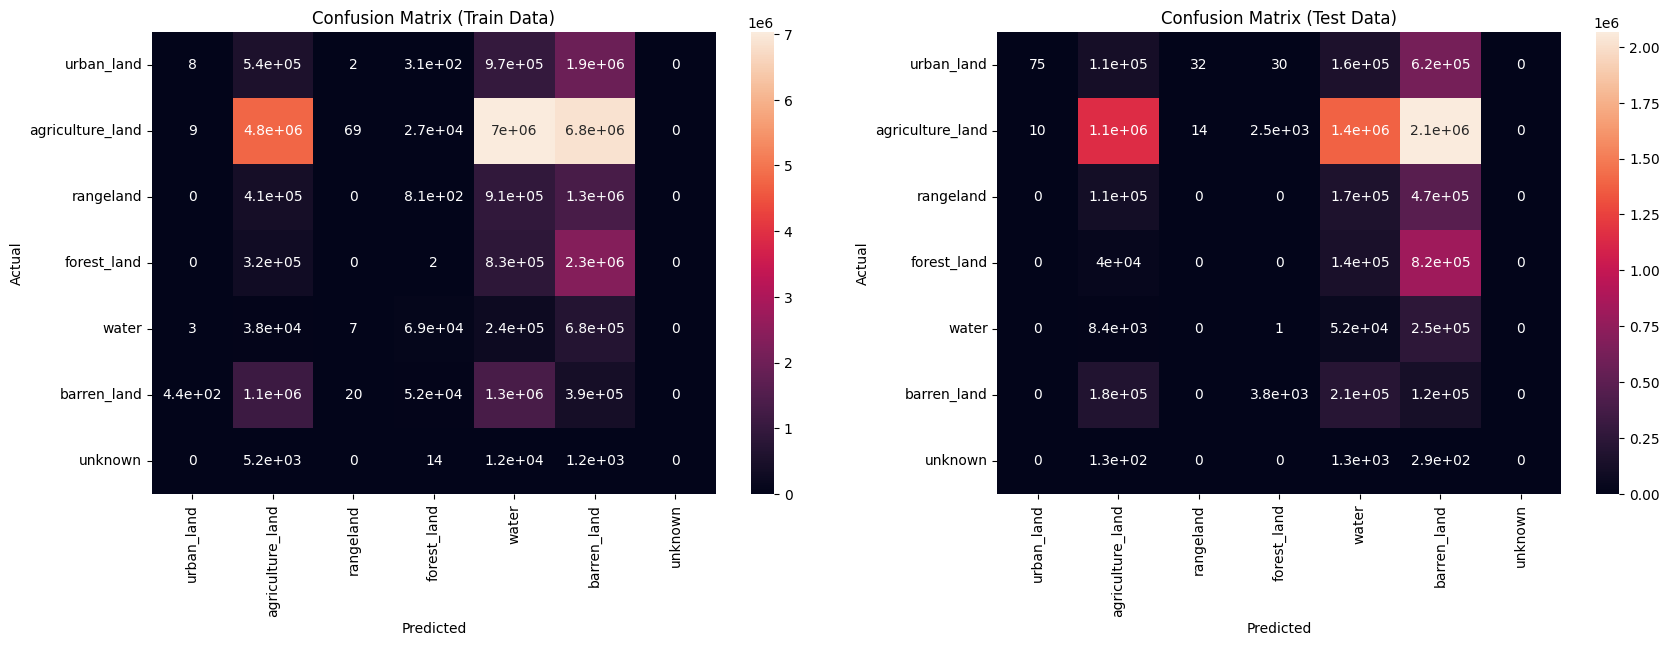

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import to_categorical
import seaborn as sns
import pandas as pd


def display_confusion_matrix(keras_model, x_train, y_train, x_test, y_test, labels):

    actual_y_train = keras_model.predict(x_train)
    actual_y_test = keras_model.predict(x_test)

    plt.figure(figsize=(20,6))

    labels = np.array(labels)


    # Convert the target labels into the categorical index
    #
    y_train_index = y_train.argmax(axis=-1)
    actual_y_train_index = actual_y_train.argmax(axis=-1)
    y_test_index = y_test.argmax(axis=-1)
    actual_y_test_index = actual_y_test.argmax(axis=-1)


    # Convert the matrix to an column array
    y_train_index = y_train_index.reshape(1, -1).flatten()
    actual_y_train_index = actual_y_train_index.reshape(1, -1).flatten()

    y_test_index = y_test_index.reshape(1, -1).flatten()
    actual_y_test_index = actual_y_test_index.reshape(1, -1).flatten()


    # Print the first Confusion Matrix for the training data
    #
    cm = confusion_matrix(y_train_index, actual_y_train_index)

    cm_df = pd.DataFrame(cm, labels, labels)
    plt.subplot(1, 2, 1)
    plt.title('Confusion Matrix (Train Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # Print the second Confusion Matrix for the test data
    #
    cm = confusion_matrix(y_test_index, actual_y_test_index)


    cm_df = pd.DataFrame(cm, labels, labels)
    plt.subplot(1, 2, 2)
    plt.title('Confusion Matrix (Test Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    plt.show()


# Exclude the O tags from the confusion matrix.
#
display_confusion_matrix(model, X_train, y_train, X_val, y_val, labels)

In [ ]:
# 3 - Load checkpointed model for continuation of training or predict validation set
from tensorflow.keras.models import load_model

# model = load_model('/content/drive/MyDrive/ad-hoc_data/archive/train_2024-02-17 12-38-44/u_net_model.0077-acc-0.78-val_acc-0.66-loss-0.95.h5')

6/6 [==============================] - 1s 265ms/step


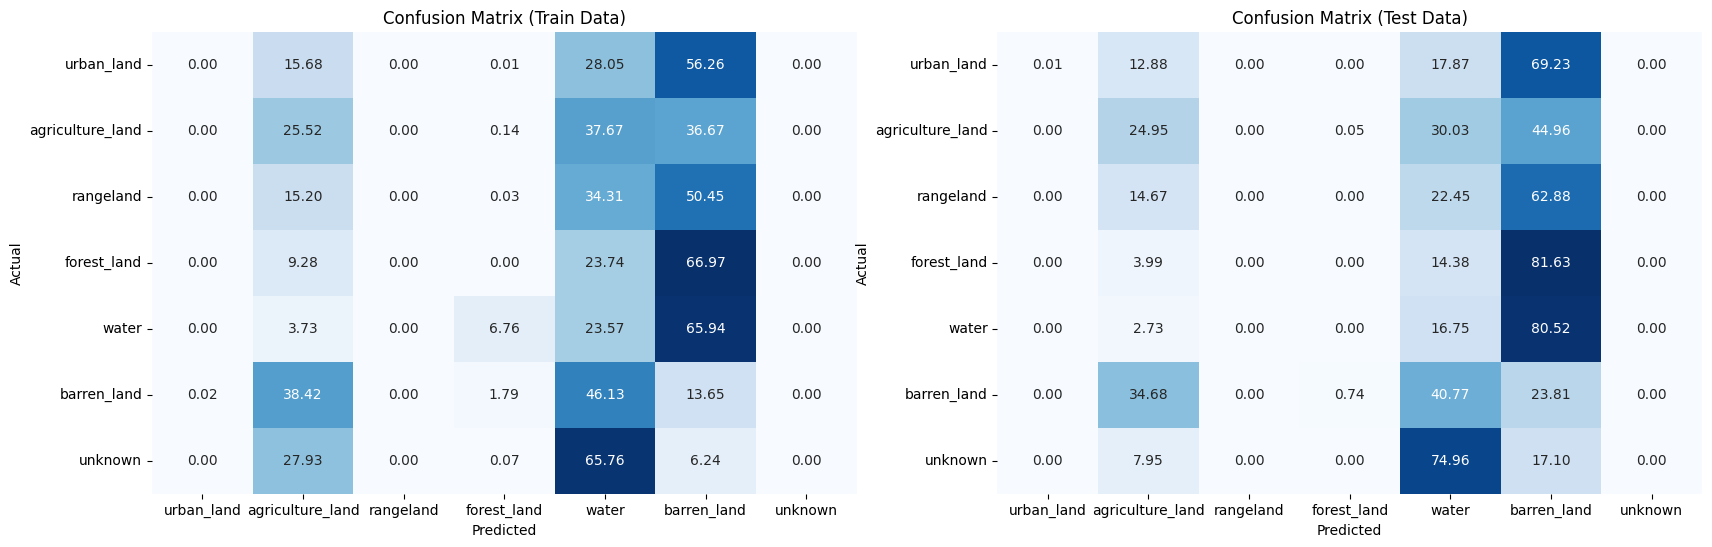

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import seaborn as sns
import pandas as pd

def display_confusion_matrix_as_pct(keras_model, x_train, y_train, x_test, y_test, labels):
    actual_y_train = keras_model.predict(x_train)
    actual_y_test = keras_model.predict(x_test)

    plt.figure(figsize=(20, 6))

    labels = np.array(labels)

    # Convert the target labels into the categorical index
    y_train_index = y_train.argmax(axis=-1)
    actual_y_train_index = actual_y_train.argmax(axis=-1)
    y_test_index = y_test.argmax(axis=-1)
    actual_y_test_index = actual_y_test.argmax(axis=-1)

    # Convert the matrix to a column array
    y_train_index = y_train_index.reshape(1, -1).flatten()
    actual_y_train_index = actual_y_train_index.reshape(1, -1).flatten()
    y_test_index = y_test_index.reshape(1, -1).flatten()
    actual_y_test_index = actual_y_test_index.reshape(1, -1).flatten()

    def plot_confusion_matrix(ax, y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred)
        cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100  # Calculate percentages

        cm_df = pd.DataFrame(cm_percentage, labels, labels)
        sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=ax)
        ax.set_title(title)
        ax.set_ylabel('Actual')
        ax.set_xlabel('Predicted')

    # Plot the first Confusion Matrix for the training data
    ax1 = plt.subplot(1, 2, 1)
    plot_confusion_matrix(ax1, y_train_index, actual_y_train_index, 'Confusion Matrix (Train Data)')

    # Plot the second Confusion Matrix for the test data
    ax2 = plt.subplot(1, 2, 2)
    plot_confusion_matrix(ax2, y_test_index, actual_y_test_index, 'Confusion Matrix (Test Data)')

    plt.show()

# Assuming you have x_train, y_train, x_test, y_test, labels defined
# model is your trained Keras model
display_confusion_matrix_as_pct(model, X_train, y_train, X_val, y_val, labels)


## Further Work and next steps

* Apply transfer learning to get improved accuracy and IoU (VGG and ResNet)
* Explore other light-weight models like MobileNet and EfficientNet
* Code refactoring and create application `app.py` and other library files
* Simple Deployment Case - build Gradio interface for simple user testing
* Full Deployment in Docker (build AI server, Flask Server and Web Server containers)